In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#dataset loading
df = pd.read_csv("C:/Users/avish/Desktop/Sem 8/Final Project/Heart_Disease_Prediction/CVD/data/heart.csv")

In [3]:
# Rename columns (from your previous code)
df = df.rename(
    columns={
        'cp': 'chest_pain_type',
        'trestbps': 'resting_blood_pressure',
        'chol': 'cholesterol',
        'fbs': 'fasting_blood_sugar',
        'restecg': 'resting_electrocardiogram',
        'thalach': 'max_heart_rate_achieved',
        'exang': 'exercise_induced_angina',
        'oldpeak': 'st_depression',
        'slope': 'st_slope',
        'ca': 'num_major_vessels',
        'thal': 'thalassemia'
    }
)

In [4]:
# dropping the wrong ca vlaues and error values from thal
df = df[df['num_major_vessels']<4]
df = df[df['thalassemia']>0]
print(f'The length of the data row now is {len(df)} instead of 1025')

The length of the data row now is 1000 instead of 1025


In [5]:
# Define features and target
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Check class distribution before SMOTE
print("Class distribution before SMOTE:", pd.Series(y).value_counts().to_dict())

Class distribution before SMOTE: {1: 508, 0: 492}


In [6]:
# Apply SMOTE to balance classes
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:", pd.Series(y).value_counts().to_dict())

Class distribution after SMOTE: {0: 508, 1: 508}


In [7]:
# Split into train (80%), validation (10%), test (10%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1111, random_state=42)

In [8]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [9]:
# Reshape for deep learning (CNN and Transformer expect 3D input: samples, features, 1)
X_train_dl = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_dl = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_dl = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Print shapes
print("X_train shape:", X_train.shape, "X_train_dl shape:", X_train_dl.shape)
print("X_val shape:", X_val.shape, "X_val_dl shape:", X_val_dl.shape)
print("X_test shape:", X_test.shape, "X_test_dl shape:", X_test_dl.shape)
print("y_train shape:", y_train.shape, "y_val shape:", y_val.shape, "y_test shape:", y_test.shape)

X_train shape: (812, 13) X_train_dl shape: (812, 13, 1)
X_val shape: (102, 13) X_val_dl shape: (102, 13, 1)
X_test shape: (102, 13) X_test_dl shape: (102, 13, 1)
y_train shape: (812,) y_val shape: (102,) y_test shape: (102,)


In [10]:
# Define CNN model
cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=(13, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

C:\Users\avish\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Train model
cnn_history = cnn_model.fit(
    X_train_dl, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_dl, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5168 - loss: 0.6928 - val_accuracy: 0.7157 - val_loss: 0.6400
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7410 - loss: 0.5911 - val_accuracy: 0.7843 - val_loss: 0.5287
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8111 - loss: 0.4623 - val_accuracy: 0.7941 - val_loss: 0.4547
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8406 - loss: 0.3752 - val_accuracy: 0.8137 - val_loss: 0.4697
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8302 - loss: 0.3900 - val_accuracy: 0.8137 - val_loss: 0.4368
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8624 - loss: 0.3354 - val_accuracy: 0.8235 - val_loss: 0.4301
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8903 - loss: 0.2791 - val_accuracy: 0.8235 - val_loss: 0.4655
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8991 - loss: 0.2971 - val_accuracy: 0.8235 - v

In [12]:
# Evaluate on test set
cnn_test_pred_proba = cnn_model.predict(X_test_dl).flatten()
cnn_test_pred = (cnn_test_pred_proba > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [13]:
# Metrics
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test_dl, y_test, verbose=0)
cnn_test_pred_proba = cnn_model.predict(X_test_dl).flatten()
cnn_test_pred = (cnn_test_pred_proba > 0.5).astype(int)
cnn_accuracy = accuracy_score(y_test, cnn_test_pred)
cnn_report = classification_report(y_test, cnn_test_pred, output_dict=True)
cnn_cm = confusion_matrix(y_test, cnn_test_pred)
cnn_fpr, cnn_tpr, _ = roc_curve(y_test, cnn_test_pred_proba)
cnn_roc_auc = auc(cnn_fpr, cnn_tpr)

print("CNN Test Performance Metrics:")
print(f"Test Loss: {cnn_test_loss:.4f}")
print(f"Test Accuracy: {cnn_test_accuracy*100:.2f}%")
print(f"Accuracy (sklearn): {cnn_accuracy*100:.2f}%")
print(f"ROC-AUC: {cnn_roc_auc:.2f}")
print(f"Recall: {cnn_report['1']['recall']:.2f}")
print(f"Precision: {cnn_report['1']['precision']:.2f}")
print(f"F1-Score: {cnn_report['1']['f1-score']:.2f}")
print("Confusion Matrix:\n", cnn_cm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
CNN Test Performance Metrics:
Test Loss: 0.0757
Test Accuracy: 97.06%
Accuracy (sklearn): 97.06%
ROC-AUC: 1.00
Recall: 0.95
Precision: 1.00
F1-Score: 0.97
Confusion Matrix:
 [[41  0]
 [ 3 58]]


In [15]:
# Check for underfitting/overfitting
train_loss_final = cnn_history.history['loss'][-1]
val_loss_final = cnn_history.history['val_loss'][-1]
train_acc_final = cnn_history.history['accuracy'][-1]
val_acc_final = cnn_history.history['val_accuracy'][-1]

print("\nCNN Underfitting/Overfitting Analysis:")
print(f"Final Training Loss: {train_loss_final:.4f}, Validation Loss: {val_loss_final:.4f}")
print(f"Final Training Accuracy: {train_acc_final*100:.2f}%, Validation Accuracy: {val_acc_final*100:.2f}%")
if train_loss_final > val_loss_final + 0.1 or train_acc_final < 0.7:
    print("Possible Underfitting: Training loss is high or accuracy is low.")
elif val_loss_final > train_loss_final + 0.1 and val_acc_final < train_acc_final - 0.1:
    print("Possible Overfitting: Validation loss/accuracy significantly worse than training.")
else:
    print("Good Fit: Training and validation metrics are close.")


CNN Underfitting/Overfitting Analysis:
Final Training Loss: 0.1064, Validation Loss: 0.1263
Final Training Accuracy: 95.94%, Validation Accuracy: 92.16%
Good Fit: Training and validation metrics are close.


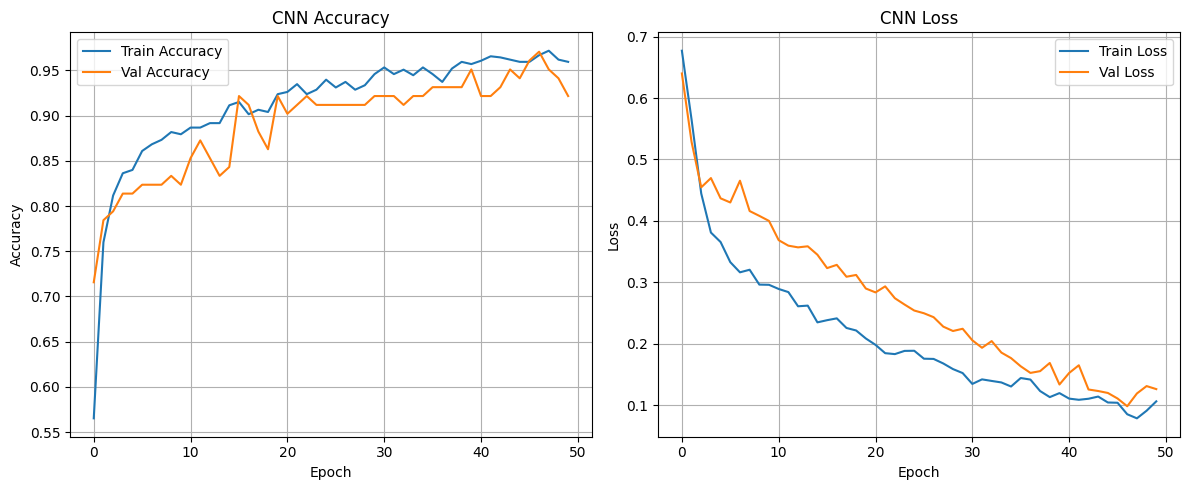

In [16]:
# Plot accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(cnn_history.history['accuracy'], label='Train Accuracy')
ax1.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('CNN Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(cnn_history.history['loss'], label='Train Loss')
ax2.plot(cnn_history.history['val_loss'], label='Val Loss')
ax2.set_title('CNN Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()